# 패키지 설치


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyLDAvis
!pip install selenium
!pip install jamo
!pip install BeautifulSoup4
!apt update
!apt install chromium-chromedriver

#Install Mecab

In [4]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 75 (delta 33), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [5]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [6]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 460kB 39.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-12-14 19:15:17--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c3:9b0a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloa

In [7]:
cd /content/mecab-ko-dic-2.1.1-20180720

/content/mecab-ko-dic-2.1.1-20180720


In [8]:
cp "/content/drive/My Drive/GitHub/2020-2-OSSP1-WhatsUp-5/text_mining/data/nnp.csv" "./user-dic/nnp.csv"

In [ ]:
!bash ./tools/add-userdic.sh

In [10]:
!make install

make[1]: Entering directory '/content/mecab-ko-dic-2.1.1-20180720'
make[1]: Nothing to be done for 'install-exec-am'.
 /bin/mkdir -p '/usr/local/lib/mecab/dic/mecab-ko-dic'
 /usr/bin/install -c -m 644 model.bin matrix.bin char.bin sys.dic unk.dic left-id.def right-id.def rewrite.def pos-id.def dicrc '/usr/local/lib/mecab/dic/mecab-ko-dic'
make[1]: Leaving directory '/content/mecab-ko-dic-2.1.1-20180720'


#Install Java

In [11]:
cd /content

/content


In [12]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


#Install Mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [14]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities


# spacy for lemmatization
import spacy
 
# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
 
 
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data


In [15]:
cd "/content/drive/My Drive/GitHub/2020-2-OSSP1-WhatsUp-5/text_mining"

/content/drive/My Drive/GitHub/2020-2-OSSP1-WhatsUp-5/text_mining


In [16]:
from utils import get_stopword, df_to_dic, to_syn, preprocess, get_nouns_from_csv

In [17]:
from konlpy.tag import Mecab
import pandas as pd
from tqdm import tqdm

In [18]:
from health_chosun_crawling import get_article

# Load Data

In [ ]:
#data = get_article()

In [76]:
import pandas as pd
data = pd.read_csv("data/article_20201110-20201210.csv")
data.head()

,Unnamed: 0,name,date,content
0,0,"샐러드 먼저, 밥 나중에… 순서만 바꿔도 살 빠진다",2020.12.10,체중 관리를 해야 하는데 운동하거나 식사량을 줄이기 어렵다면 먹는 순서를 바꿔보자....
1,1,나도 혹시 거북목? 자가진단법 5가지,2020.12.10,코로나19로 인해 비대면 활동이 활성화되면서 '스마트폰'과 'PC' 사용량이 늘고 ...
2,2,"대웅제약 ‘나보타’, 대상포진 후 신경통증 감소 효과 입증",2020.12.09,대웅제약은 보툴리눔 톡신 제제 ‘나보타’의 대상포진 후 신경통증에 대한 효과가 ‘베...
3,3,"윤대원 일송학원 이사장, 웁살라대학교 린네 금메달 수상",2020.12.09,학교법인 일송학원 윤대원 이사장이 스웨덴 웁살라대학교가 주관하는 ‘린네 메달(Lin...
4,4,"초고해상 MRI用 마그넷, 가천브레인밸리 도착… 시스템 조립 착수",2020.12.09,가천대 길병원은 극초고해상도 11.74T MRI 시스템 개발의 핵심 부품 ‘마그넷(...


In [77]:
# Load Stopword
stopword = get_stopword()
df = pd.read_csv("data/disease_list.csv", encoding="utf-8")

synonym = df_to_dic(df=df)

# load article data and extract nouns
word_list = get_nouns_from_csv(data=data, stopword=stopword, synonym=synonym)

100%|██████████| 738/738 [00:02<00:00, 306.57it/s]


Noun Extraction Complete


# LDA 분석

In [23]:
from LDAutils import compute_coherence_values, coherence_graph, mallet_to_lda

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
# create Dictionary
id2word=corpora.Dictionary(word_list)
id2word.filter_extremes(no_below=20)

# create Corpus
texts = word_list

# Term Document Frequency
corpus=[id2word.doc2bow(text) for text in texts]

## Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [79]:
# LDA lib Mallet 환경설정
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [80]:
limit=31; start=6; step=3;
model_list, coherence_values, topic_idx = compute_coherence_values(mallet_path=mallet_path ,id2word=id2word, 
                                                        corpus=corpus, texts=texts, 
                                                        start=start, limit=limit, step=step)

100%|██████████| 9/9 [06:00<00:00, 40.02s/it]


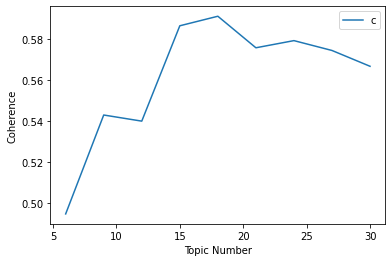

In [81]:
# 생성한 모델 list의 일관성 점수 그래프
coherence_graph(start=start, limit=limit, step=step, 
                coherence_values=coherence_values, path="output/coherence_values.png")

In [92]:
# 적절한 mallet LDA 모델을 선택하여 Gensim LDA 모델로 변환
ldamallet = model_list[topic_idx]
model = mallet_to_lda(ldamallet)

# Model 저장 및 평가(Coherence Score)
생성된 모델을 저장하거나 복구한다.

In [93]:
from gensim.test.utils import datapath
lda_path = "./model/model.lda"
model.save(lda_path)

In [94]:
# Compute Coherence Score

print('\nCoherence Score: ', coherence_values[topic_idx])



Coherence Score:  0.5862624134508976


# Model 백업 및 평가(Coherence Score)

In [90]:
lda_path = "./model/model.lda"
model = gensim.models.LdaModel.load(lda_path)

In [89]:
# LDA Load 했을시
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5862624134508976


# LDA 토픽 분석 결과

In [95]:
from LDAutils import summary

In [96]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word, R=15)
pyLDAvis.display(vis)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [97]:
# pyLDAvis 결과 저장
pyLDAvis.save_html(vis, './output/LDA_Map.html')

In [98]:
result = summary(model=model, corpus=corpus, texts=texts)
result

,Keywords,Num_Documents,Perc_Documents
0,"운동, 통증, 근육, 관절, 무릎, 다리, 척추, 신경, 허리, 손상",160,0.2168
1,"감염, 이상, 예방, 환자, 건강, 활동, 호흡기, 호흡, 전문가, 면역",100,0.1355
2,"사용, 피부, 성분, 효과, 염증, 물질, 제거, 예방, 세균, 제품",94,0.1274
3,"수술, 검사, 진단, 환자, 치료, 암, 최근, 교수, 가능, 시행",63,0.0854
4,"질환, 혈관, 환자, 치료, 혈액, 심장, 이상, 고혈압, 뇌졸중, 수축",47,0.0637
5,"위험, 여성, 증가, 당뇨병, 호르몬, 이상, 남성, 폐경, 건강, 알코올",46,0.0623
6,"증상, 발생, 원인, 대사, 습관, 유발, 스트레스, 악화, 치료, 생활",38,0.0515
7,"연구, 결과, 교수, 그룹, 분석, 대상, 미국, 평균, 게재, 감소",32,0.0434
8,"치료, 기능, 장애, 치매, 건강, 복용, 우울증, 저하, 환자, 수면",31,0.0420
9,"병원, 의료, 학회, 교수, 진료, 정보, 환자, 원장, 분야, 소아",26,0.0352


# 질병명 추출
+ 종성 추가

In [99]:
from utils import get_disease_in_keywords

In [100]:
df = pd.read_csv("data/disease_list.csv", encoding="utf-8")
df = get_disease_in_keywords(result_df=result, disease_df=df)
df

,disease,jongsung
0,고혈압,T
1,당뇨병,T
2,폐경,T
3,코로나19,F
4,치매,F
5,우울증,T
6,뇌졸중,T


In [101]:
# 질병명 추출 결과 저장
df.to_csv("output/disease_keyword.csv", index=False)